In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [2]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [3]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)
returns_index = returns_index.stack().rename("returns")

# # Portfolio returns
# period = (2001, 2004)
# cpis = dm.cpis.get_data(period=period)
# wb = dm.wb.get_data(countries=major, period=period)
# weights = compute_weights(cpis, wb, major, offshore).mean(axis=1).unstack(level="Country")
# returns_portfolio = compute_portfolio_excess_returns(ds, fed, major, weights)

# World market return
returns_world = compute_index_excess_returns(ds, fed, ["WR"]).to_numpy().flatten()
returns_world_dummies = pd.DataFrame(0.0, index=returns_index.index, columns=major)
for country in major:
    returns_world_dummies.loc[(country, slice(None)), country] = returns_world
returns_world_dummies.columns = ['WRx' + str(col) for col in returns_world_dummies.columns]

# GDP per capita
interpolate=False
period = (2001, 2004) if not interpolate else (2000,2004)
gdp_cap_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_cap_ppp")
gdp_cap_ppp = create_monthly_duplicates(gdp_cap_ppp, panel_dates, interpolate=interpolate)
gdp_cap_ppp = gdp_cap_ppp.stack().rename("gdp_cap")

# GDP growth (lagged yearly)
d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
lags = range(1,2)
for lag in lags:
    period = (2000-lag,2004-lag) if not interpolate else (1999-lag,2004-lag)
    gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
    d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
    d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, panel_dates, interpolate=interpolate)
    d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.stack().rename(f"lag{lag}")

# GDP growth (lagged monthly)
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# period = (1997,2004)
# n_lags = (2001 - period[0])*12
# columns = dm.ds.get_data(period=period, interval="M").columns[13:]
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
# d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
# d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, monthly_columns=columns, interpolate=interpolate)
# d_gdp_ppp
# lags = range(1, 37)
# for lag in lags:
#     d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.iloc[:, 36-lag:-lag].T.unstack().to_numpy()
# d_gdp_ppp_lag = d_gdp_ppp_lag.iloc[:, range(0,1)]

# Cumulative GDP growth
d_gdp_ppp_cum = d_gdp_ppp_lag.sum(axis=1)

# Variances (rolling window, exponential decay)
def calculate_exponentially_weighted_variance(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_index_historical = compute_index_excess_returns(ds, fed, major)
    variances = pd.DataFrame(index=major, columns=panel_dates)
    for i in range(48):
        returns = returns_index_historical.iloc[:,i:i+60]
        means = returns.mean(axis=1)
        returns_demeaned = returns.sub(means, axis=0)
        var_contributions = returns_demeaned**2
        factors = generate_exponential_decay(ratio=ratio)
        vars = var_contributions.mul(factors).sum(axis=1) / sum(factors)
        variances.iloc[:,i] = vars
    variances = variances.stack().rename("variances").astype(float)
    return variances
variances = calculate_exponentially_weighted_variance((1996,2004), panel_dates, 0.9)

In [4]:
from scipy.optimize import minimize_scalar

period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_index_historical = compute_index_excess_returns(ds, fed, major)
returns_index_demeaned = returns_index - returns_index.groupby("Country").mean()
returns_index_demeaned_squared = (returns_index_demeaned ** 2)

def compute_r2(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    # model = sm.OLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
    # model = PanelOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa), entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    model = PooledOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    return -model.rsquared


def compute_ss(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    errors = variances_kappa - returns_index_demeaned_squared
    ss = (errors ** 2).to_numpy().sum()
    return ss

kappa_ss = minimize_scalar(compute_ss, bounds=(0,1), method="bounded")
kappa_r2 = minimize_scalar(compute_r2, bounds=(0,1), method="bounded")
print(kappa_r2.x, kappa_ss.x)
print(kappa_r2.fun, kappa_ss.fun)

0.9058656466188171 0.8914021213249128
-0.16591934722811563 0.2678562235517841


In [5]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = PooledOLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

Dep. Variable:,returns,R-squared:,0.3081
Estimator:,PooledOLS,R-squared (Between):,0.9738
No. Observations:,1824,R-squared (Within):,0.0057
Date:,"Thu, May 01 2025",R-squared (Overall):,0.3081
Time:,21:15:01,Log-likelihood,5488.3
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,811.70
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(1,1823)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,122.74


In [6]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = sm.OLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
fe_model = PanelOLS(returns_index_demeaned_squared, variances_kappa, entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

from linearmodels.panel import compare

# Estimate both models
re_model = RandomEffects(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)

# Hausman test

comparison = hausman(fe_model, re_model)
print(comparison)

(np.float64(5.906802770555258), 1, np.float64(0.015082521769819666))


In [7]:
# Collect dependent and independent variables
scale = True
y = returns_index * (1e2 if scale else 1)
X = pd.concat([
    variances * (1e2 if scale else 1),
    # gdp_cap_ppp / (1e3 if scale else 1),
    d_gdp_ppp_cum * (1e2 if scale else 1),
    returns_world_dummies * (1e2 if scale else 1),
], axis=1)
X = sm.add_constant(X)

In [8]:
# Do statistics
from linearmodels.panel import PanelOLS, PooledOLS

model_panel = PanelOLS(y, X, entity_effects=True).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)
model_pooled = PooledOLS(y,X).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)

comparison = pd.DataFrame([model_pooled.params, model_panel.params], index=["pooled", "panel"])
date = model_panel.estimated_effects.index.get_level_values(1)[0]

effects = model_panel.estimated_effects.loc[(slice(None), date),:].droplevel(1)

if save is not None:
    save_dir = f"./output/exp3/results/"
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    with open(os.path.join(save_dir, f"{save}.txt"), "w") as f:
        f.write(model_panel.summary.as_text())
model_panel.summary

Dep. Variable:,returns,R-squared:,0.4443
Estimator:,PanelOLS,R-squared (Between):,-0.2583
No. Observations:,1824,R-squared (Within):,0.4443
Date:,"Thu, May 01 2025",R-squared (Overall):,0.4343
Time:,21:15:04,Log-likelihood,-5780.7
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,34.897
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(40,1746)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,2.876e+05


In [9]:
model_panel.params.iloc[4:].mean()

np.float64(1.041767668098189)

In [10]:
model_panel.total_ss

108764.09501166995

In [11]:
model_panel.resid_ss

60441.85281518445

In [12]:
model_panel.model_ss

48322.2421964855

In [13]:
tss = np.sum((y - y.mean())**2)
tss

np.float64(110327.82314964611)

In [14]:
# Expected world return
period = (1991,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_world = compute_index_excess_returns(ds, fed, ["WR"])
returns_world_expectation = np.zeros(48)
for i in range(48):
    returns = returns_world.iloc[:,i:i+120]
    mean = returns.mean(axis=1).iloc[0]
    returns_world_expectation[i] = mean

In [15]:
params_for_estimation = model_panel.params.copy()
X_for_estimation = X.copy()
for country in major:
    world_return_header = "WRx" + country
    X_for_estimation.loc[(country, slice(None)), world_return_header] = returns_world_expectation
fitted_returns = (X_for_estimation * params_for_estimation)
fitted_returns = fitted_returns.sum(axis=1).unstack()
(fitted_returns < 0).sum(axis=1)

AR    0
AT    0
BE    0
BR    0
CA    0
CH    0
CL    0
CO    0
CZ    0
DE    0
DK    0
ES    0
FI    0
FR    0
GB    0
GR    0
HK    0
HU    0
ID    0
IL    0
IT    0
JP    0
KR    0
MX    0
MY    0
NL    0
NO    0
PH    0
PL    0
PT    0
RU    0
SE    0
SG    0
TH    0
TR    0
US    0
VE    0
ZA    0
dtype: int64

In [16]:
variances

AR  2001-01-31    0.005594
    2001-02-28    0.009731
    2001-03-31    0.010198
    2001-04-30    0.009204
    2001-05-31    0.008331
                    ...   
ZA  2004-08-31    0.004195
    2004-09-30    0.003764
    2004-10-31    0.003858
    2004-11-30    0.003903
    2004-12-31    0.005121
Name: variances, Length: 1824, dtype: float64

In [17]:
# Covariances
returns = returns_index.unstack()
returns_mean = returns.mean(axis=1)
returns_demeaned = returns.sub(returns_mean, axis=0)
stds = variances.map(lambda x: np.sqrt(x)).unstack()
standardised_returns = returns_demeaned / stds / 100
corrs = standardised_returns.T.corr()
covs = pd.DataFrame(index=major, columns=pd.MultiIndex.from_product([stds.columns, major]))
for month in stds.columns:
    covs[month] = corrs.mul(stds[month],axis=1).mul(stds[month],axis=0)

In [18]:
fitted_returns.mean(axis=1)

AR    1.894600
AT    0.742952
BE    0.788351
BR    1.329636
CA    0.636765
CH    0.812110
CL    0.530515
CO    0.719504
CZ    0.782407
DE    1.023662
DK    0.865757
ES    0.572836
FI    1.189764
FR    0.825131
GB    0.593601
GR    0.628791
HK    0.683332
HU    0.662903
ID    1.102928
IL    0.882861
IT    0.869547
JP    0.896964
KR    0.729481
MX    0.922776
MY    0.450727
NL    0.834891
NO    0.809680
PH    0.675494
PL    0.914093
PT    0.866873
RU    0.779182
SE    0.937162
SG    0.572145
TH    0.845022
TR    2.511014
US    0.677456
VE    2.003345
ZA    0.733033
dtype: float64

In [19]:
# Covariance risks
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)
cov_risks = pd.DataFrame(index=covs.index, columns=covs.columns)
cov_risks_diag = pd.DataFrame(index=covs.index, columns=stds.columns)
for month in stds.columns:
    temp = covs[month] @ weights
    cov_risks[month] = temp
    cov_risks_diag[month] = np.diag(temp)

In [20]:
# eta * f
eta_f = (fitted_returns / 100) / cov_risks_diag

C:\Users\nilsv\AppData\Local\Temp\ipykernel_19124\1100132001.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


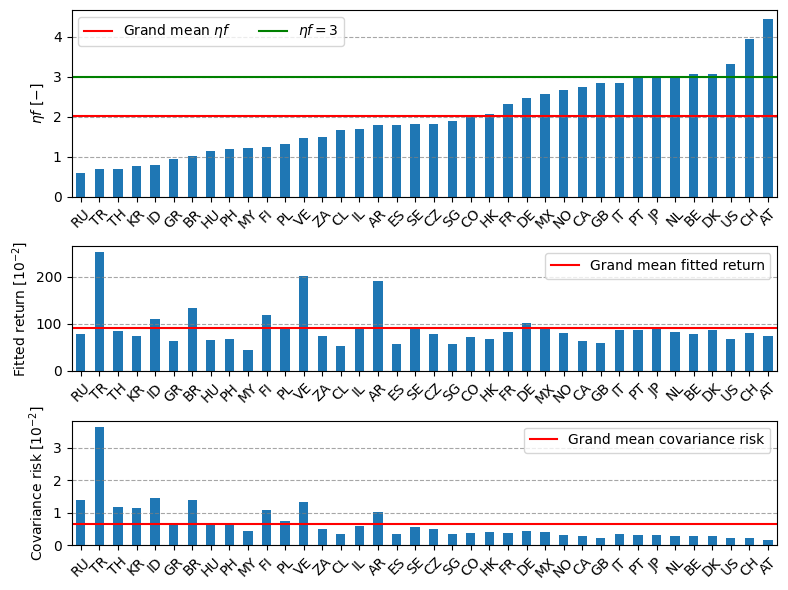

In [21]:
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(3, 1, figsize=(8,6), gridspec_kw={'height_ratios': [3, 2, 2]})

eta_f_mean = eta_f.mean(axis=1).sort_values()
eta_f_mean.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(eta_f_mean.mean(), color="red")
axs[0].axhline(3, color="green")
axs[0].legend(labels=[r"Grand mean $\eta f$", r"$\eta f = 3$"], ncol=2)
axs[0].set_ylabel(r"$\eta f$ $[\mathrm{-}]$") 

fitted_returns_mean = 100*fitted_returns.mean(axis=1).reindex(eta_f_mean.index)
fitted_returns_mean.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(fitted_returns_mean.mean(), color="red")
axs[1].legend(labels=["Grand mean fitted return"], ncol=2)
axs[1].set_ylabel(r"Fitted return $[10^{-2}]$") 

cov_risks_mean = 100*cov_risks_diag.mean(axis=1).reindex(eta_f_mean.index)
cov_risks_mean.plot(kind="bar", ax=axs[2])
axs[2].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[2].get_xticklabels():
    label.set_ha('center')
axs[2].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[2].axhline(cov_risks_mean.mean(), color="red")
axs[2].legend(labels=["Grand mean covariance risk"], ncol=2)
axs[2].set_ylabel(r"Covariance risk $[10^{-2}]$") 

fig.tight_layout()
fig.savefig(dir+"/eta_f.svg")
fig.show()

In [22]:
# Fastest way
costs_9 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
for country_i in major:
    for month in stds.columns:
        costs_9[(month, country_i)] = fitted_returns[month] - 100*eta_f.loc[country_i, month] * covs[month] @ weights[country_i] 
    print(country_i, end=" ")
costs = costs_9
print("\n")


AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



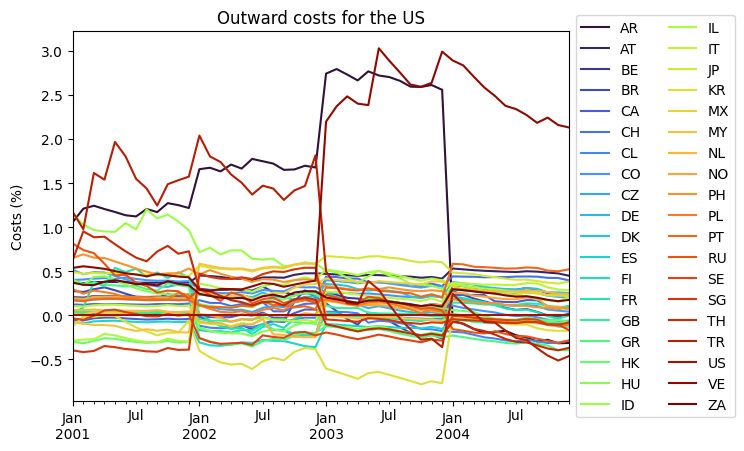

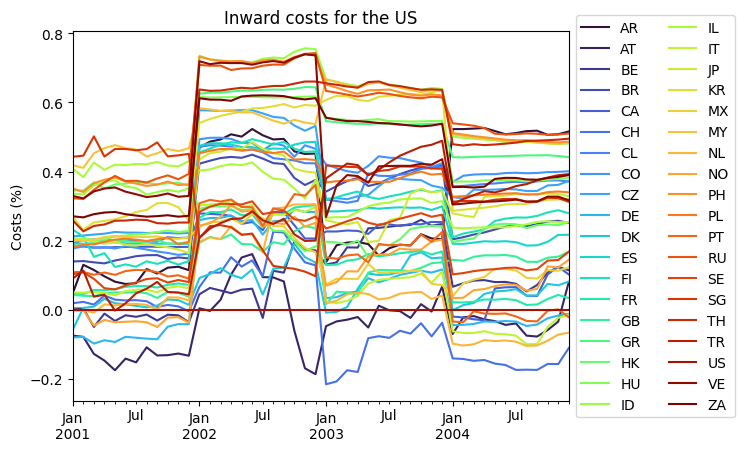

In [23]:
import matplotlib.cm as cm
data_outward = costs.loc[slice(None), (slice(None), "US")].T.droplevel(level=1)
data_inward = costs.loc["US"].unstack()
color = plt.get_cmap("turbo", 38)
ax = data_outward.plot(title="Outward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
ax = data_inward.plot(title="Inward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.show()

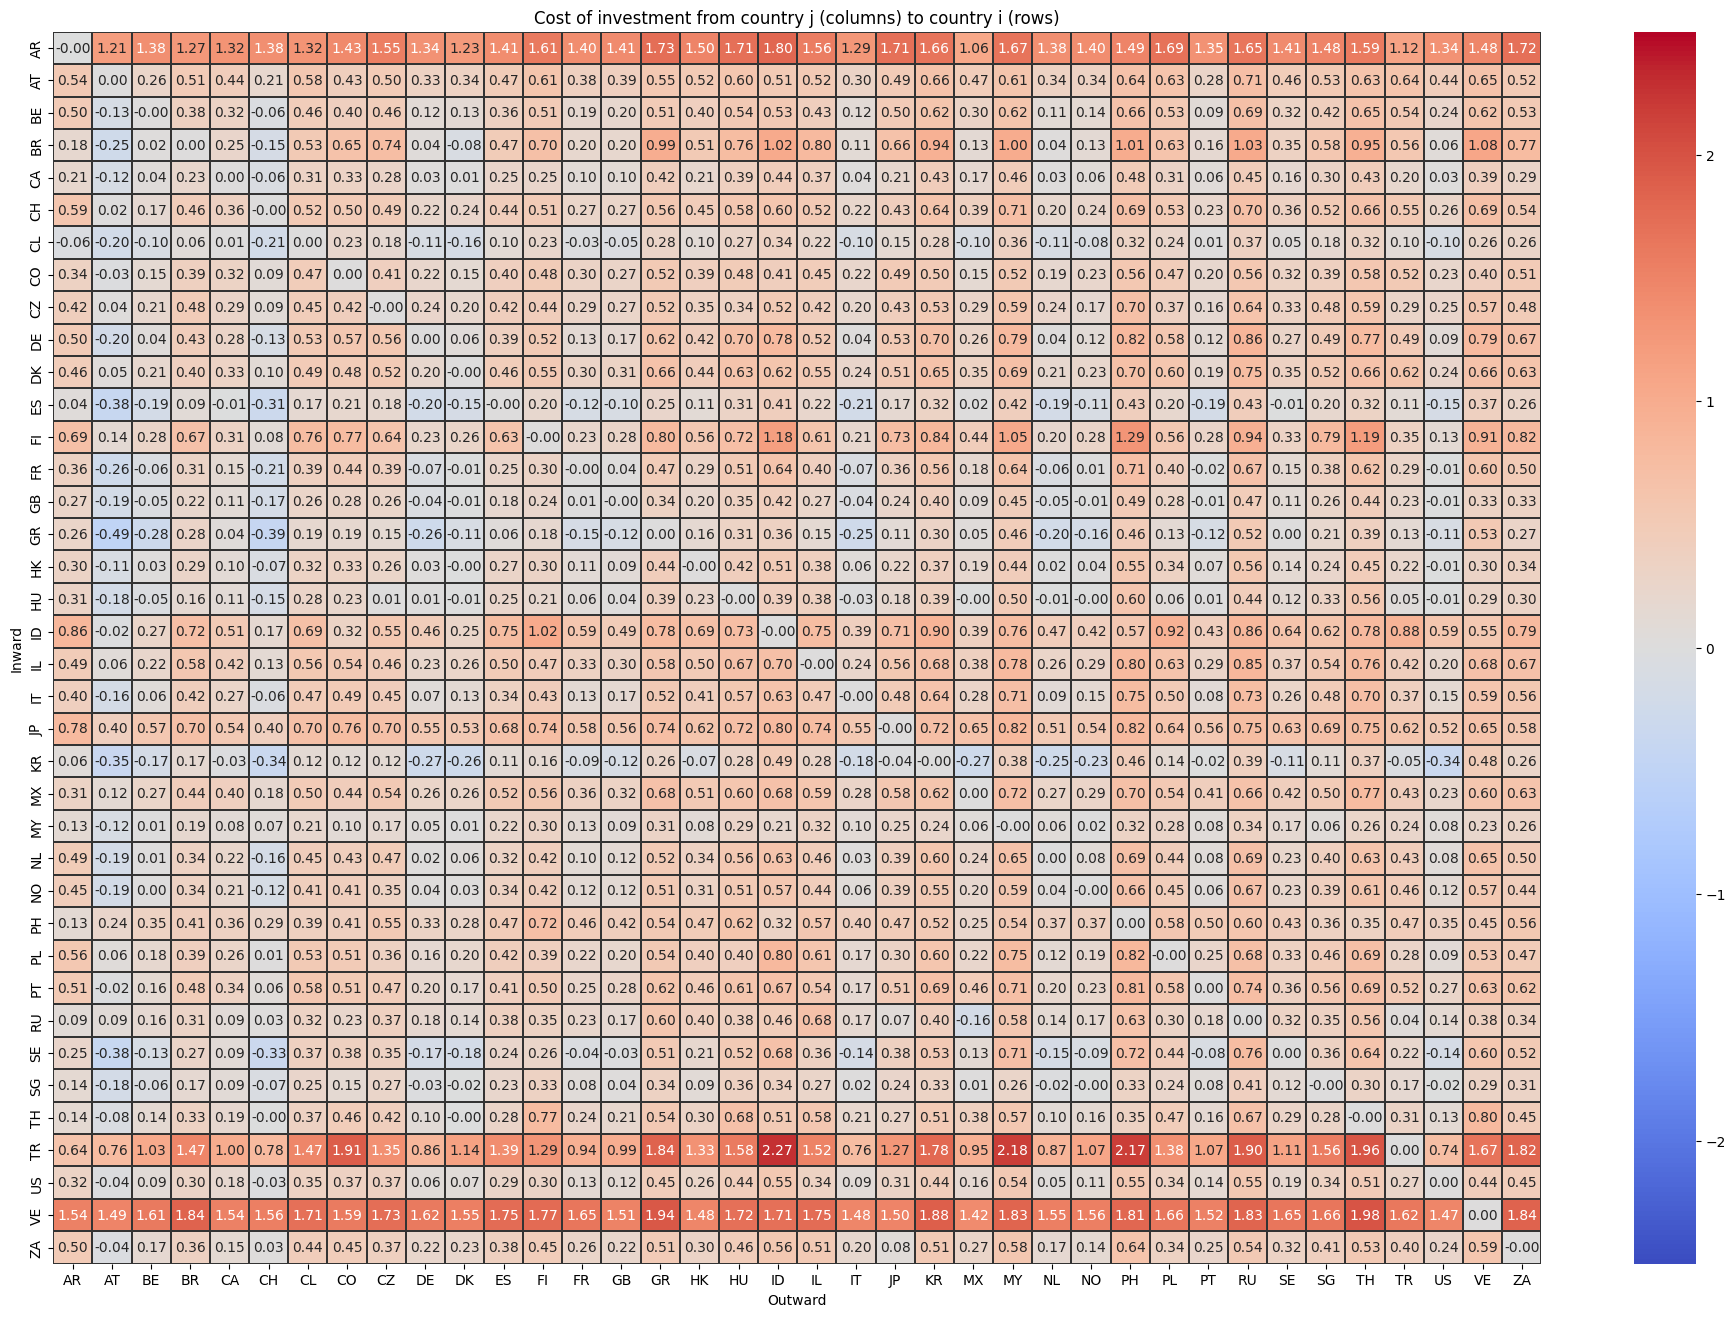

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
costs_mean = costs.T.groupby(level=1).mean().T
costs_mean = costs_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(costs_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

C:\Users\nilsv\AppData\Local\Temp\ipykernel_11212\2047976204.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


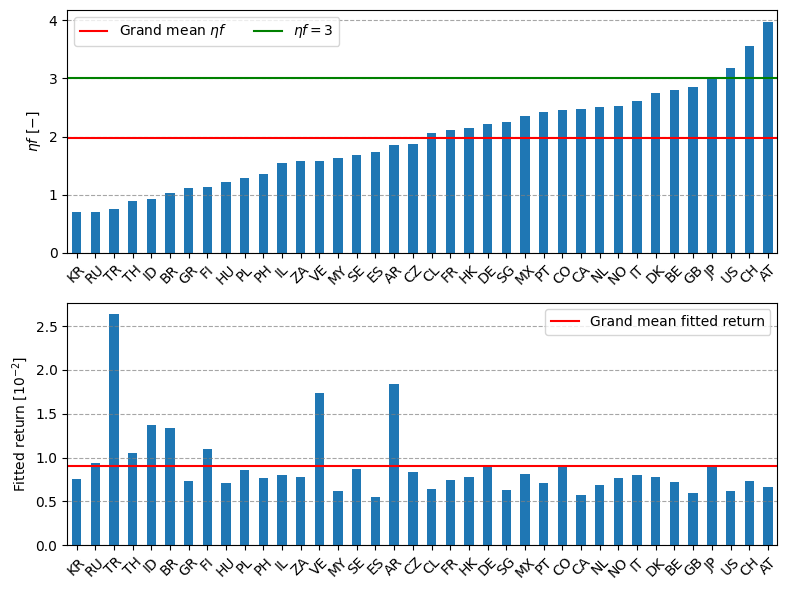

In [25]:
mean_inward_cost = costs_mean.mean(axis=1).sort_values()
mean_outward_cost = costs_mean.mean(axis=0).sort_values()
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [1,1]})

eta_f_mean = eta_f.mean(axis=1).sort_values()
eta_f_mean.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(eta_f_mean.mean(), color="red")
axs[0].axhline(3, color="green")
axs[0].legend(labels=[r"Grand mean $\eta f$", r"$\eta f = 3$"], ncol=2)
axs[0].set_ylabel(r"$\eta f$ $[\mathrm{-}]$") 

fitted_returns_mean = fitted_returns.mean(axis=1).reindex(eta_f_mean.index)
fitted_returns_mean.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(fitted_returns_mean.mean(), color="red")
axs[1].legend(labels=["Grand mean fitted return"], ncol=2)
axs[1].set_ylabel(r"Fitted return $[10^{-2}]$") 

fig.tight_layout()
fig.savefig(dir+"/costs_mean.svg")
fig.show()

In [26]:
print("average over means: ", (costs_mean<0).sum().sum()/38**2)
print("average over all obs.: ", (costs_9<0).sum().sum()/38**2/48)

average over means:  0.07271468144044321
average over all obs.:  0.09800611726685134


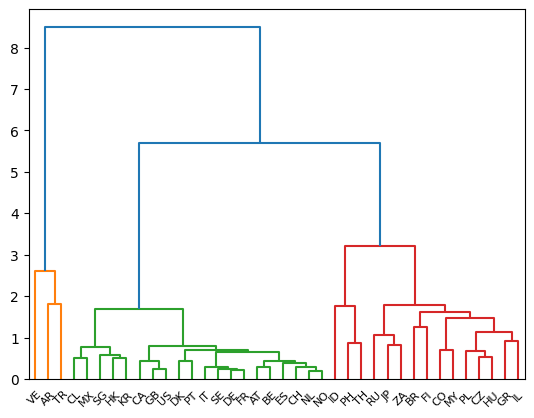

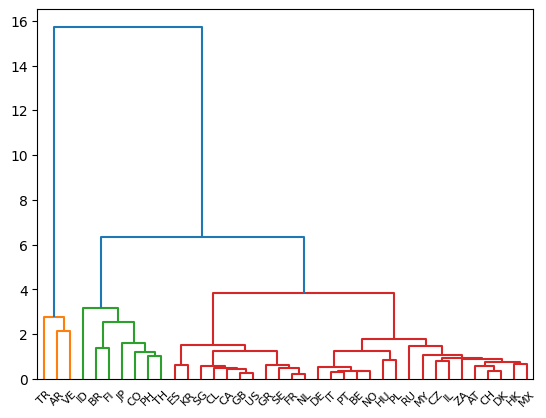

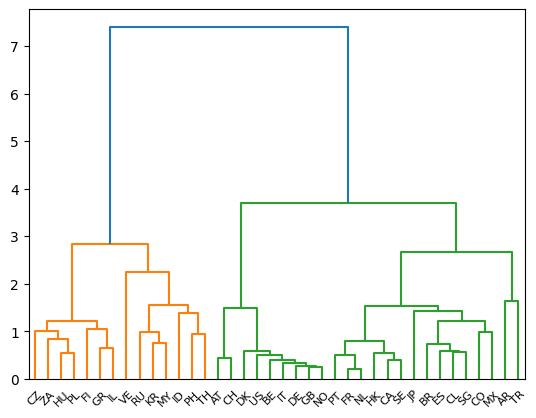

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Based on average cost between i and j
A = (costs_mean + costs_mean.T)/2 + 1
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on rows = inward costs
A = costs_mean
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on columns = outward costs
A = costs_mean.T
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

In [28]:
cost_gap = pd.DataFrame(0.0, index=costs.index, columns=costs.columns)
for country_i in major: 
    for country_j in major:
        if country_j <= country_i:
            continue            
        for month in stds.columns:
            weights_i = weights[country_i]
            weights_j = weights[country_j]
            cov_i = covs[month].loc[country_i]
            cov_j = covs[month].loc[country_j]
            eta_f_i = eta_f.loc[country_i, month]
            eta_f_j = eta_f.loc[country_j, month]
            weights_diff = (3*(weights_i-weights_j) - (eta_f_i*weights_i - eta_f_j*weights_j))
            cost_gap.loc[country_i, (month, country_j)] =  cov_i @ weights_diff
            cost_gap.loc[country_j, (month, country_i)] =  cov_j @ -weights_diff
    print(country_i, end=" ")
print("\n")

AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



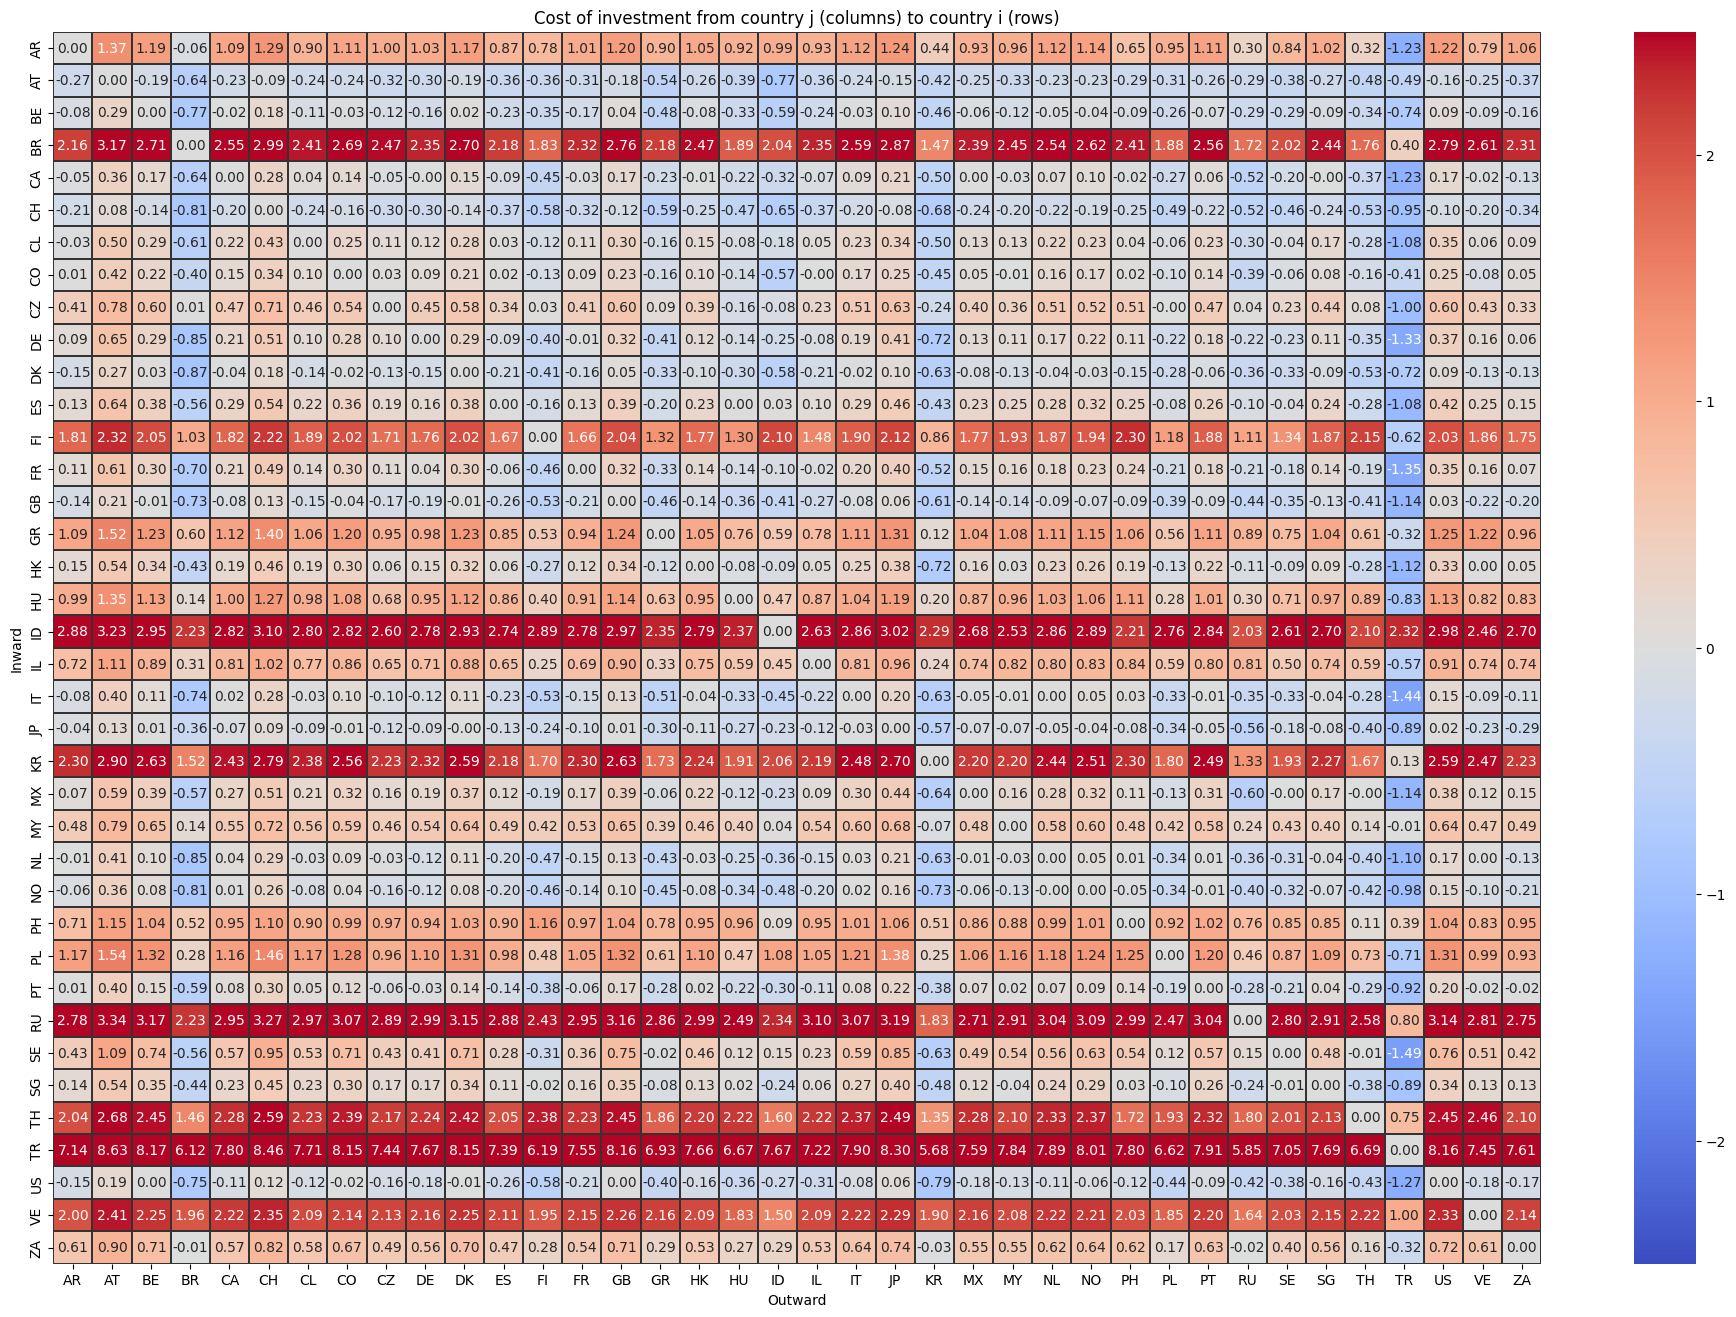

In [29]:
cost_gap_mean = 100*cost_gap.T.groupby(level=1).mean().T
cost_gap_mean = cost_gap_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(cost_gap_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

In [30]:
plot_average_costs_per_country(cost_gap_mean, gap=True, ylim=(-1,8))

NameError: name 'plot_average_costs_per_country' is not defined